

Architureect
- enc_blks = [1, 1, 1, 28]
- middle_blk_num = 1
- dec_blks = [1, 1, 1,

Augmentaion
- Horizontal Flip
- Vertical Flip
- 2 X 2 Patch 증강

CONFIG
- Learning rate = 1e-3
- Batch size    = 8

Performace
- epoch : 60   
- Loss: 50.69027757644653
- PSNR: 49.30972242355347
- SSIM: 0.9960637912154198

In [ ]:
!pip install gdown

In [ ]:
pip install torch-summary

In [ ]:
import gdown
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import cv2
!pip install ptflops

from ptflops import get_model_complexity_info
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
!pip install torchmetrics-
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp

In [4]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
gdown.download_folder(id='1hlMr2ruSB3sO_5hFJvqOJUdm4yIpu3mN', output='/kaggle/working/')

In [89]:
# 256 data만 사용
noisy_images = np.load('/kaggle/working/SIDD/noisy_images_256.npy')
gt_images = np.load('/kaggle/working/SIDD/gt_images_256.npy')

In [90]:
# len, C, H, W
print(gt_images.shape)
print(noisy_images.shape)

(160, 3, 256, 256)
(160, 3, 256, 256)


In [ ]:
indices = np.arange(len(noisy_images))
np.random.shuffle(indices)

# Use the same shuffled indices for shuffling both arrays
noisy_images = noisy_images[indices]
gt_images = gt_images[indices]



num_images_to_display = 4 * 5

plt.figure(figsize=(18, 6*num_images_to_display))

# Permute axis for each image pair before displaying
for i in range(num_images_to_display):
    # Permute axis for noisy image
    noisy_image_permuted = noisy_images[i].transpose(1,2,0)   # (C, H, W) -> (H, W, C)
    
    # Permute axis for ground truth image
    gt_image_permuted = gt_images[i].transpose(1,2,0)   # (C, H, W) -> (H, W, C)
    
    # Plot noisy image 
    plt.subplot(num_images_to_display, 4, i*2 + 1)   # subplot(nrows, ncols, index=1,3,5)
    plt.imshow(noisy_image_permuted)
    plt.title(f"Noisy Image{i+1}")
    plt.axis('off')
    
    # Plot ground truth image
    plt.subplot(num_images_to_display, 4, i*2 + 2)   # subplot(nrows, ncols, index=2,4,6)
    plt.imshow(gt_image_permuted)
    plt.title(f"Ground Truth Image{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
length = len(noisy_images)
train = int(length * 0.8)
val = int(length * 0.9)
print(f"Train : {train}, Validation : {val}")

In [ ]:
class LayerNormFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)


def replace_layers(model, base_size, train_size, fast_imp, **kwargs):
    for n, m in model.named_children():
        if len(list(m.children())) > 0:
            ## compound module, go inside it
            replace_layers(m, base_size, train_size, fast_imp, **kwargs)

        if isinstance(m, nn.AdaptiveAvgPool2d):
            pool = AvgPool2d(base_size=base_size, fast_imp=fast_imp, train_size=train_size)
            assert m.output_size == 1
            setattr(model, n, pool)


'''
ref.
@article{chu2021tlsc,
  title={Revisiting Global Statistics Aggregation for Improving Image Restoration},
  author={Chu, Xiaojie and Chen, Liangyu and and Chen, Chengpeng and Lu, Xin},
  journal={arXiv preprint arXiv:2112.04491},
  year={2021}
}
'''
class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma


class NAFNet(nn.Module):

    def __init__(self, img_channel=3, width=32, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)    # 최종적으로는 채널 3으로 나가야하니깐.

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        #------------------------------------------------------------------#
        self.fftBlock = nn.ModuleList() 
        #------------------------------------------------------------------#

        chan = width

        for num in enc_blk_nums:    # enc_blks = [1, 1, 1, 28] 
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]    # middle_blk_num = 1
            )

        for num in dec_blk_nums:    # dec_blks = [1, 1, 1, 1]
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan*2, kernel_size=1, bias=False),   # point-wise conv. 채널 수 2배 뻥튀기
                    
                    nn.PixelShuffle(upscale_factor=2)   # Feature map의 수많은 channel을 이용하여, pixel 위치에 맞는 각 Channel의 값을 떼어와서 feature map 확장  # 논문 참고 (https://mole-starseeker.tistory.com/m/84)
                                                        # 이미지를 가로 세로 2배씩 확장한다면, 채널은 4개가 필요함 // 따라서 채널이 upscale_factor ** 2 만큼 감소
                )
            )
            chan = chan // 2    # 채널 수 다시 2배 감소
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )


        self.padder_size = 2 ** len(self.encoders)  # == len(enc_blk_nums) == 4, down으로 인해 감소된 배수

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        
        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x


# Example usage:
input_tensor = torch.randn(1, 3, 256, 256)  # Example input tensor
# model = HalfUNet()
model = NAFNet()
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Print the shape of the output tensor

torch.Size([1, 3, 256, 256])


In [43]:
# 설정 변경 
if __name__ == '__main__':
    img_channel = 3
    width = 32

    # enc_blks = [2, 2, 4, 8]
    # middle_blk_num = 12
    # dec_blks = [2, 2, 2, 2]

    # enc_blks = [1, 1, 1, 1]
    # middle_blk_num = 1
    # dec_blks = [1, 1, 1, 1]

    # NAFNet 기본 config
    enc_blks = [1, 1, 1, 28]
    middle_blk_num = 1
    dec_blks = [1, 1, 1, 1]

    model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
                      enc_blk_nums=enc_blks, dec_blk_nums=dec_blks)


    inp_shape = (3, 256, 256)

In [45]:
model = model.to(device)

In [46]:
from torchsummary import summary
result = summary(model, (3, 256 ,256))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 32, 256, 256]        896
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-1                        [-1, 32, 256, 256]        --
|    |    └─NAFBlock: 3-1                     [-1, 32, 256, 256]        8,224
├─ModuleList: 1                               []                        --
|    └─Conv2d: 2-2                            [-1, 64, 128, 128]        8,256
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-3                        [-1, 64, 128, 128]        --
|    |    └─NAFBlock: 3-2                     [-1, 64, 128, 128]        30,784
├─ModuleList: 1                               []                        --
|    └─Conv2d: 2-4                            [-1, 128, 64, 64]         32,896
├─ModuleList: 1                               []                        --
|    

In [27]:
# Original Version (Patch X)
class ImageDataset(Dataset):
    def __init__(self, noise, gt):
        # Transforms for low resolution images and high resolution images
        self.noise = noise
        self.gt = gt

    def __getitem__(self, index):
        noise = self.noise[index % len(self.noise)]

        gt =self.gt[index % len(self.gt)]

        return (noise, gt)

    def __len__(self):
        return len(self.noise)

In [105]:
# Fixed Version (Patch O)

class DenoisingDataset(Dataset):
    def __init__(self, noisy_images, gt_images, crop_size=256):
        self.noisy_images = noisy_images  # Shape: (N, 3, H, W)
        self.gt_images = gt_images  # Shape: (N, 3, H, W)
        self.crop_size = crop_size

        self.noisy_patches = []
        self.gt_patches = []

        for img_idx in tqdm((range(len(self.noisy_images)))):
            image = self.noisy_images[img_idx]  # Shape: (3, H, W)
            mask = self.gt_images[img_idx]  # Shape: (3, H, W)

            _, h, w = image.shape
            mid_h, mid_w = h // 2, w // 2

            patches_coords = [
                (0, 0, mid_h, mid_w),
                (0, mid_w, mid_h, w),
                (mid_h, 0, h, mid_w),
                (mid_h, mid_w, h, w)
            ]

            for y1, x1, y2, x2 in patches_coords:
                noisy_patch = image[:, y1:y2, x1:x2]
                gt_patch = mask[:, y1:y2, x1:x2]

                noisy_patch = torch.from_numpy(
                    cv2.resize(noisy_patch.transpose(1, 2, 0), (crop_size, crop_size))
                ).permute(2, 0, 1).float()
                gt_patch = torch.from_numpy(
                    cv2.resize(gt_patch.transpose(1, 2, 0), (crop_size, crop_size))
                ).permute(2, 0, 1).float()

                self.noisy_patches.append(noisy_patch)
                self.gt_patches.append(gt_patch)

    def __getitem__(self, idx):
        return self.noisy_patches[idx], self.gt_patches[idx]

    def __len__(self):
        return len(self.noisy_patches)


In [92]:
noisy_images[:train].shape

(128, 3, 256, 256)

In [22]:
# sidd
# noisy_train, gt_train = noisy_images[:train].transpose(0,2,3,1), gt_images[:train].transpose(0,2,3,1)
# noisy_test, gt_test = noisy_images[train:], gt_images[train:]

# del noisy_images
# del gt_images

In [93]:
noisy_train, gt_train = noisy_images[:train].transpose(0,2,3,1), gt_images[:train].transpose(0,2,3,1) # (C, H, W) -> (H, W, C)
noisy_val, gt_val =  noisy_images[train:val], gt_images[train:val]
noisy_test, gt_test = noisy_images[val:], gt_images[val:]

del noisy_images
del gt_images

In [94]:
print("noisy_train : ",  noisy_train.shape)
print("gt_train :" ,gt_train.shape)
print("\nnoisy_val :", noisy_val.shape)
print("gt_val :", gt_val.shape)
print("\nnoisy_test :", noisy_test.shape)
print("gt_test :", gt_test.shape)

noisy_train :  (128, 256, 256, 3)
gt_train : (128, 256, 256, 3)

noisy_val : (16, 3, 256, 256)
gt_val : (16, 3, 256, 256)

noisy_test : (16, 3, 256, 256)
gt_test : (16, 3, 256, 256)


In [95]:
horizontal_flip = A.Compose([
    A.HorizontalFlip(p=1)
])

noisy_train_horizontal = []
gt_train_horizontal = []

for i in range(len(noisy_train)):
    augmented = horizontal_flip(image=noisy_train[i])
    noisy_train_horizontal.append(augmented['image'])

    augmented = horizontal_flip(image=gt_train[i])
    gt_train_horizontal.append(augmented['image'])

noisy_train_horizontal = np.array(noisy_train_horizontal)
gt_train_horizontal = np.array(gt_train_horizontal)
gt_train_horizontal.shape

(128, 256, 256, 3)

In [96]:
vertical_flip = A.Compose([
    A.VerticalFlip(p=1)
])

noisy_train_vertical = []
gt_train_vertical = []

for i in range(len(noisy_train)):
    augmented = vertical_flip(image=noisy_train[i])
    noisy_train_vertical.append(augmented['image'])

    augmented = vertical_flip(image=gt_train[i])
    gt_train_vertical.append(augmented['image'])

noisy_train_vertical = np.array(noisy_train_vertical)
gt_train_vertical = np.array(gt_train_vertical)
gt_train_vertical.shape

(128, 256, 256, 3)

In [ ]:
num_images_to_display = 4

plt.figure(figsize=(24, 6*num_images_to_display))

for i in range(num_images_to_display):
    plt.subplot(num_images_to_display, 4, 4*i+1)
    plt.imshow(noisy_train[i+1])
    plt.title('Image noise {}'.format(i+1))
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4*i+2)
    plt.imshow(noisy_train_vertical[i+1])
    plt.title('Vertical noise {}'.format(i+1))
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4*i+3)
    plt.imshow(gt_train_horizontal[i+1])
    plt.title('horizontal noise {}'.format(i+1))
    plt.axis('off')

    plt.subplot(num_images_to_display, 4, 4*i+4)
    plt.imshow(gt_train_vertical[i+1])
    plt.title('GT {}'.format(i+1))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [97]:
# Train만 증강 (noisy_original + noisy_vertical + noisy_horizontal (128 x 3) + 이후 데이터셋 구성에서 Patch)
noisy_train = np.vstack((noisy_train, noisy_train_vertical, noisy_train_horizontal)).transpose(0, 3, 1, 2)
gt_train = np.vstack((gt_train, gt_train_vertical, gt_train_horizontal)).transpose(0, 3, 1, 2)

print(noisy_train.shape)
print(gt_train.shape)

print(noisy_train.dtype)
print(gt_train.dtype)

(384, 3, 256, 256)
(384, 3, 256, 256)
float32
float32


In [ ]:
# Fixed Version (2 X 2 Patch 증강)
train_dataloader = DataLoader(DenoisingDataset(noisy_train, gt_train), batch_size=8, shuffle=True, num_workers=4)
val_dataloader = DataLoader(DenoisingDataset(noisy_val, gt_val), batch_size=8, shuffle=True, num_workers=4)
test_dataloader = DataLoader(DenoisingDataset(noisy_test, gt_test), batch_size=8, shuffle=True, num_workers=4)

In [109]:
# Patch 증강으로 데이터 4배씩 증가
print(f"Train : {len(train_dataloader.dataset)}")
print(f"Validation : {len(val_dataloader.dataset)}")
print(f"Test : {len(test_dataloader.dataset)}")

Train : 1536
Validation : 64
Test : 64


In [110]:
from torchmetrics.image import StructuralSimilarityIndexMeasure


ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)   # SSIM : 인간의 시각적 화질 차이를 평가하기 위해 고안

def psnr(img1, img2, data_range=1.0):                                # PSNR : MSE를 통해 화질의 손실 정보 계산
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) between two images.

    Args:
        img1 (torch.Tensor): Input image tensor, shape (batch_size, channels, height, width).
        img2 (torch.Tensor): Input image tensor, shape (batch_size, channels, height, width).
        data_range (float): Range of valid pixel values in the image. Default is 1.0.

    Returns:
        torch.Tensor: PSNR value, shape (batch_size,)
    """
    mse = F.mse_loss(img1, img2)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val

def loss_func(x,y):
    return 100-psnr(x,y)

# loss_func = nn.MSELoss()

In [111]:
def evaluate_model(model, dataloader, device=device):
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute metrics
            loss_val = loss_func(outputs, targets)
            psnr_val = psnr(outputs, targets)
            ssim_val = ssim(outputs, targets)

            total_loss += loss_val.item()
            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()

    avg_loss = total_loss/ len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    avg_ssim = total_ssim / len(dataloader)

    return avg_loss, avg_psnr, avg_ssim

# Train

In [ ]:
train_loss = []
train_psnr = []
train_ssim = []
val_loss = []
val_psnr = []
val_ssim = []

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()

    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_func(outputs, targets)
        psnr_val = psnr(outputs, targets)
        ssim_val = ssim(outputs,targets)

        total_loss += loss.item()
        total_psnr += psnr_val.item()
        total_ssim += ssim_val.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        loop.set_description(f'Step [{batch_idx+1}/{len(train_dataloader)}]')
        loop.set_postfix(loss=loss.item(), psnr=psnr_val.item(), ssim=ssim_val.item())

#     scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    avg_psnr = total_psnr / len(train_dataloader)
    avg_ssim = total_ssim / len(train_dataloader)

    print(f"Train Loss: {avg_loss:.4f}, Train PSNR: {avg_psnr:.4f}, Train SSIM: {avg_ssim:.4f}")

    # Evaluate the model on the test set
    avg_loss_val, avg_psnr_val, avg_ssim_val = evaluate_model(model, val_dataloader, device)
    print(f"Val Loss: {avg_loss_val}, Val PSNR: {avg_psnr_val:.4f}, Val SSIM: {avg_ssim_val:.4f}")

    train_loss.append(avg_loss)
    train_psnr.append(avg_psnr)
    train_ssim.append(avg_ssim)
    val_loss.append(avg_loss_val)
    val_psnr.append(avg_psnr_val)
    val_ssim.append(avg_ssim_val)


# Save trained model
torch.save(model.state_dict(), 'NAFNet_v4.pth')

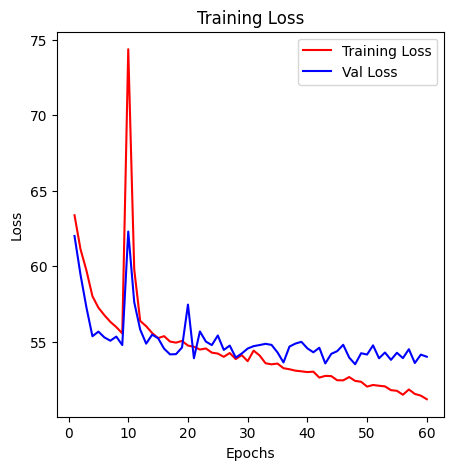

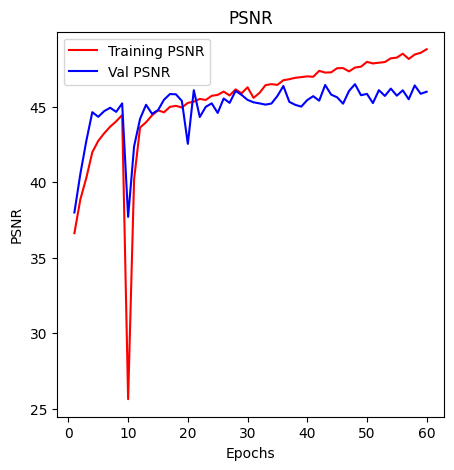

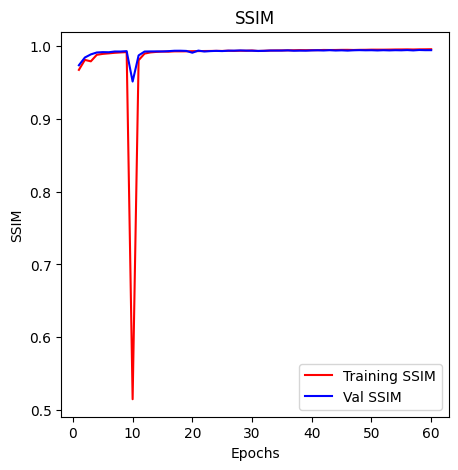

In [113]:
epochs = range(1, len(train_loss) + 1)

# Plotting train loss
plt.figure(figsize=(5, 5))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train PSNR
plt.figure(figsize=(5, 5))
plt.plot(epochs, train_psnr, 'r', label='Training PSNR')
plt.plot(epochs, val_psnr, 'b', label='Val PSNR')
plt.title('PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.show()

# Plotting train SSIM
plt.figure(figsize=(5, 5))
plt.plot(epochs, train_ssim, 'r', label='Training SSIM')
plt.plot(epochs, val_ssim, 'b', label='Val SSIM')
plt.title('SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.show()

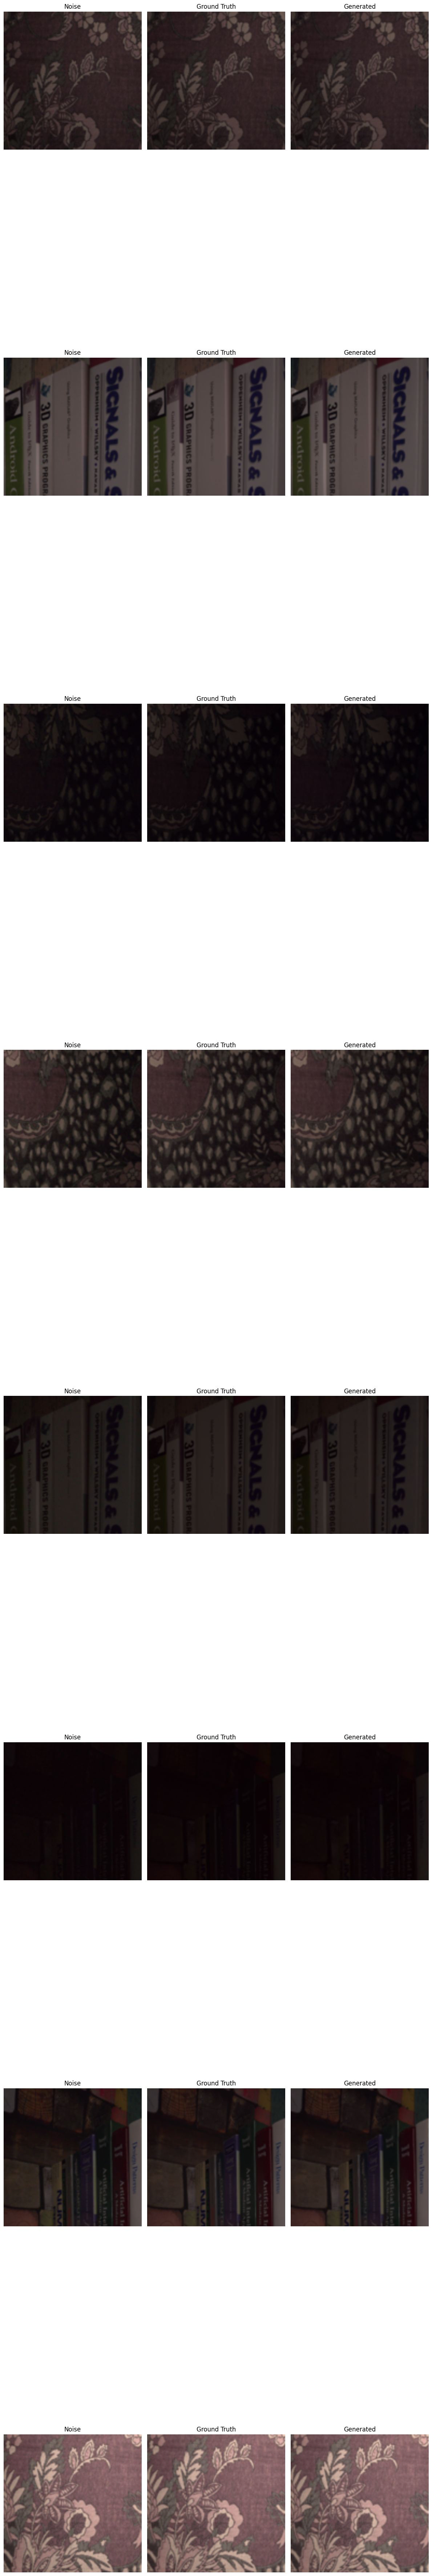

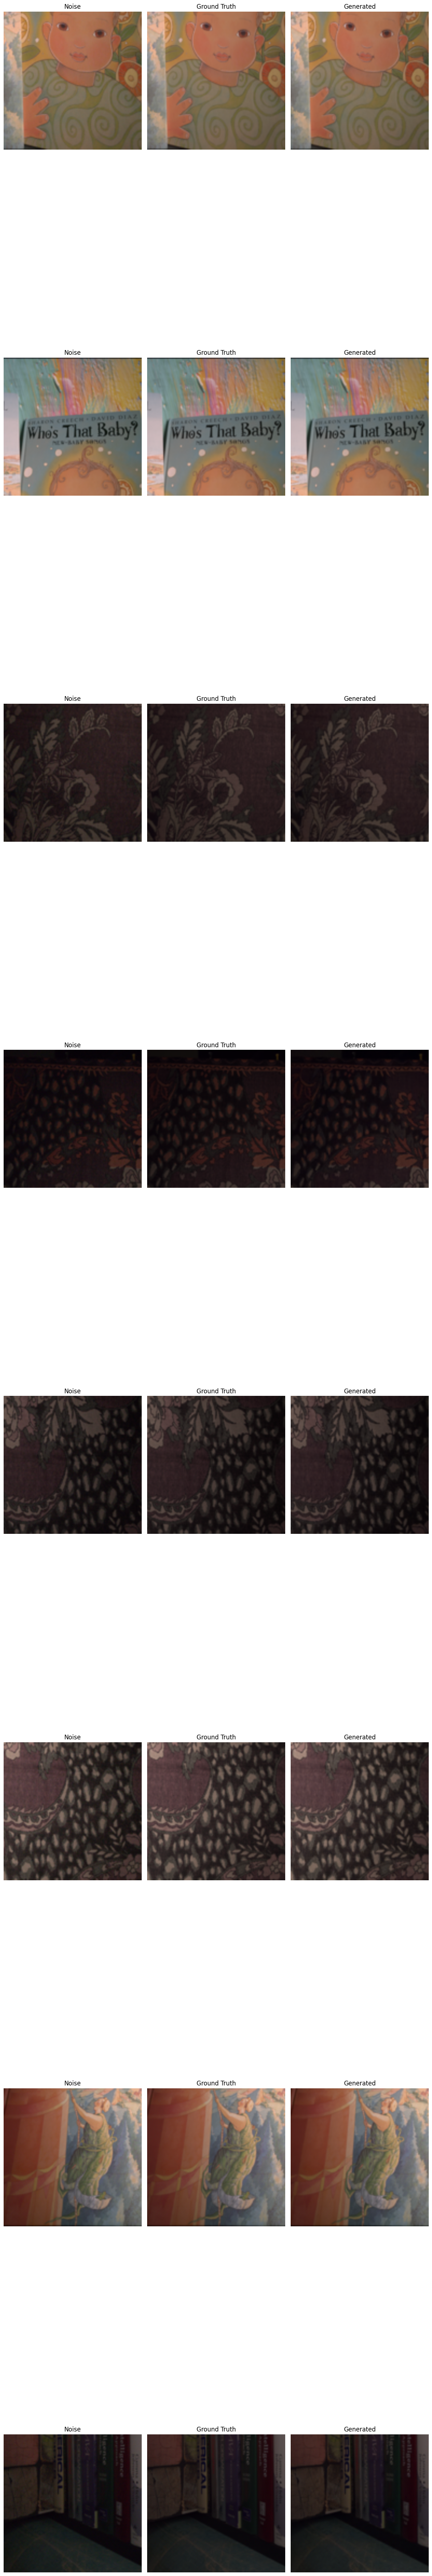

In [114]:
##### Set model to evaluation mode
from torch.autograd import Variable
model.eval()
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
# Iterate over a few batches from the test dataset

for batch_idx, (lr,hr) in enumerate(test_dataloader):
    # Get inputs
    imgs_lr = Variable(lr.type(Tensor))
    imgs_hr = Variable(hr.type(Tensor))

    # Forward pass: Generate high-resolution images
    with torch.no_grad():
        gen_hr = model(imgs_lr)

    # Visualize a few sample images
    num_samples = min(100, len(imgs_lr))

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 10))
    for i in range(num_samples):
        # Original LR image
        axes[i, 0].imshow(imgs_lr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 0].set_title("Noise")
        axes[i, 0].axis("off")

        # Ground truth HR image
        axes[i, 1].imshow(imgs_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Generated HR image
        axes[i, 2].imshow(gen_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 2].set_title("Generated")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Only visualize a few batches
    if batch_idx == 1:
        break

In [115]:
# NAFNet_v5
loss, psnr, ssim = evaluate_model(model, test_dataloader)
print(f'Loss: {loss}')
print(f'PSNR: {psnr}')
print(f'SSIM: {ssim}')

Loss: 50.69027757644653
PSNR: 49.30972242355347
SSIM: 0.9960637912154198
